## Import Libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Library to scrape Google Play
from google_play_scraper import Sort, reviews

from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import json

%matplotlib inline

## Data Collection

Users can rate [Shopee's app](https://play.google.com/store/apps/details?id=com.shopee.sg&hl=en_SG) on Google Play with a star rating and review. The ratings are on a 5-point scale, with 1 being the lowest score and 5 being the highest score one could possibly give. Since the goal of our project is to predict if a review has a positive or negative sentiment based on textual data, we will scrape real user reviews on Google Play.

[Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) provides an API to crawl through Google Play. We used `pip install google-play-scraper` to install the package and scraped users' reviews and rating scores on Shopee's app.  

The reviews were collected in batches, according to their scores (1-5). This was done in an attempt to achieve a balanced dataset with roughly the same number of reviews for each score. Also, in order to gather reviews that had more text and were written recently, we set up the google play scraper to scrape from both review types, 'Most relevant' and 'Newest'.


In [2]:
# Read in shopee csv file 
# Datetime parsing for 'at' and 'repliedAt' columns
yelp_reviews = pd.read_csv('../data/yelp_10k.csv', usecols=['text'])

In [3]:
# TAKE:  text
yelp_reviews

,text
0,My wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,General Manager Scott Petello is a good egg!!!...
...,...
9995,First visit...Had lunch here today - used my G...
9996,Should be called house of deliciousness!\n\nI ...
9997,I recently visited Olive and Ivy for business ...
9998,My nephew just moved to Scottsdale recently so...


In [4]:
yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [5]:
yelp_reviews = yelp_reviews.rename(columns={'text': 'content'})

In [6]:
yelp_reviews 

,content
0,My wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,General Manager Scott Petello is a good egg!!!...
...,...
9995,First visit...Had lunch here today - used my G...
9996,Should be called house of deliciousness!\n\nI ...
9997,I recently visited Olive and Ivy for business ...
9998,My nephew just moved to Scottsdale recently so...


In [7]:
# Read in shopee csv file 
# Datetime parsing for 'at' and 'repliedAt' columns
shopee_reviews = pd.read_csv('../data/shopee_reviews.csv', usecols=['content'])

In [8]:
# TAKE: content, score
shopee_reviews

,content
0,The app is workng fine. The issue i had was th...
1,The issue of this rated 🌟 with genuine conside...
2,Latest version of the app keeps crashing whene...
3,Payment page is such a disaster. Full of verif...
4,Be very careful when you use this platform. Ma...
...,...
7595,"Sellers are all very friendly, app will always..."
7596,Can get very cheap price compared to buy from ...
7597,"Fast service, low shipping fees, highly recomm..."
7598,Quite a good application. Have lots of items f...


In [9]:
shopee_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  7600 non-null   object
dtypes: object(1)
memory usage: 59.5+ KB


In [10]:
shopee_reviews

,content
0,The app is workng fine. The issue i had was th...
1,The issue of this rated 🌟 with genuine conside...
2,Latest version of the app keeps crashing whene...
3,Payment page is such a disaster. Full of verif...
4,Be very careful when you use this platform. Ma...
...,...
7595,"Sellers are all very friendly, app will always..."
7596,Can get very cheap price compared to buy from ...
7597,"Fast service, low shipping fees, highly recomm..."
7598,Quite a good application. Have lots of items f...


In [11]:
# Read in shopee csv file 
# Datetime parsing for 'at' and 'repliedAt' columns
craig_reviews = pd.read_csv('../data/craig_reviews.csv', usecols=['text'])

In [12]:
# TAKE: text, sentiment => compound
craig_reviews

,text
0,I initially had trouble deciding between the p...
1,Allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...
3,I bought one of the first Paperwhites and have...
4,I have to say upfront - I don't like coroporat...
...,...
1592,This is not the same remote that I got for my ...
1593,I have had to change the batteries in this rem...
1594,"Remote did not activate, nor did it connect to..."
1595,It does the job but is super over priced. I fe...


In [13]:
craig_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1597 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


In [14]:
craig_reviews = craig_reviews.rename(columns={'text': 'content'})

In [15]:
craig_reviews

,content
0,I initially had trouble deciding between the p...
1,Allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...
3,I bought one of the first Paperwhites and have...
4,I have to say upfront - I don't like coroporat...
...,...
1592,This is not the same remote that I got for my ...
1593,I have had to change the batteries in this rem...
1594,"Remote did not activate, nor did it connect to..."
1595,It does the job but is super over priced. I fe...


# Combine all dataset

In [16]:
yelp_reviews.info()
shopee_reviews.info()

craig_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  7600 non-null   object
dtypes: object(1)
memory usage: 59.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1597 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


In [17]:

# Concatenate the two DataFrames along the rows axis
reviews = pd.concat([yelp_reviews, shopee_reviews, craig_reviews], axis=0, ignore_index=True)

In [18]:
reviews.columns

Index(['content'], dtype='object')

In [19]:
reviews.reset_index(drop=True, inplace=True)

In [20]:
# We have collected 7404 reviews 
reviews.shape

(19197, 1)

In [21]:
# View first 5 rows
reviews.head()

,content
0,My wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,General Manager Scott Petello is a good egg!!!...


In [22]:
# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Print a negative review in the training set
print(reviews.loc[0,'content'])

# VADER's polarity scores for the negative review
sia.polarity_scores(reviews.loc[0,'content'])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


{'neg': 0.015, 'neu': 0.694, 'pos': 0.292, 'compound': 0.995}

In [23]:
reviews['compound'] = reviews['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [24]:
reviews['target'] = reviews['compound'].apply(lambda x: 0 if x >= 0 else 1)

In [25]:
# Check that the datatypes are correct eg. 'at' and 'repliedAt' are datetime
reviews

,content,compound,target
0,My wife took me here on my birthday for breakf...,0.9950,0
1,I have no idea why some people give bad review...,0.9950,0
2,love the gyro plate. Rice is so good and I als...,0.8988,0
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",0.9531,0
4,General Manager Scott Petello is a good egg!!!...,0.9893,0
...,...,...,...
19192,This is not the same remote that I got for my ...,-0.7405,1
19193,I have had to change the batteries in this rem...,-0.9205,1
19194,"Remote did not activate, nor did it connect to...",-0.8126,1
19195,It does the job but is super over priced. I fe...,0.8271,0


In [26]:
# Some null values in app version & developer replies
reviews.isnull().sum()

content     0
compound    0
target      0
dtype: int64

In [27]:
# Summary statistics for numerical variables
reviews.describe()

,compound,target
count,19197.000000,19197.000000
mean,0.521759,0.190603
std,0.593685,0.392787
min,-0.996400,0.000000
25%,0.238200,0.000000
50%,0.831300,0.000000
75%,0.960700,0.000000
max,0.999900,1.000000


In [28]:
# Check how many reviews were retrieved from each score
reviews['target'].value_counts().sort_index()

target
0    15538
1     3659
Name: count, dtype: int64

# Balance out the data

In [31]:
# Calculate the number of samples to drop
num_to_drop = 15538 - 3659

# Randomly select rows with target=0 to drop
to_drop = reviews[reviews['target'] == 0].sample(n=num_to_drop, random_state=42)

# Create a new DataFrame without the dropped rows
reviews = reviews.drop(to_drop.index)

In [32]:
# Check how many reviews were retrieved from each score
reviews['target'].value_counts().sort_index()

target
0    3659
1    3659
Name: count, dtype: int64

In [33]:
reviews

,content,compound,target
1,I have no idea why some people give bad review...,0.9950,0
4,General Manager Scott Petello is a good egg!!!...,0.9893,0
5,"Quiessence is, simply put, beautiful. Full wi...",0.9902,0
7,"Luckily, I didn't have to travel far to make m...",0.9517,0
9,Nobuo shows his unique talents with everything...,0.4588,0
...,...,...,...
19190,Voice remote gave out nearly a year after I pu...,0.6914,0
19192,This is not the same remote that I got for my ...,-0.7405,1
19193,I have had to change the batteries in this rem...,-0.9205,1
19194,"Remote did not activate, nor did it connect to...",-0.8126,1


# Sulpot

In [29]:
# amazon_cells_labelled dataset BASIC PRODUCT REVIEWS
# open tsv file in pandas make "content" for first column and "label" as 2nd column
amazondata = pd.read_csv('../data/amazon_cells_labelled.tsv', sep='\t', header=None, names=['content', 'target'])
amazondata['target'] = (amazondata['target'] == 0).astype(int)
amazondata

,content,target
0,So there is no way for me to plug it in here i...,1
1,"Good case, Excellent value.",0
2,Great for the jawbone.,0
3,Tied to charger for conversations lasting more...,1
4,The mic is great.,0
...,...,...
995,The screen does get smudged easily because it ...,1
996,What a piece of junk.. I lose more calls on th...,1
997,Item Does Not Match Picture.,1
998,The only thing that disappoint me is the infra...,1


In [30]:
# amazon compound = target
amazondata['compound'] = amazondata['target'].apply(lambda x: x)

In [31]:
# Check how many reviews were retrieved from each score
amazondata['target'].value_counts().sort_index()

target
0    500
1    500
Name: count, dtype: int64

In [32]:
# Create a new DataFrame for the new record
new_record1 = pd.DataFrame({'content': ['The screen has a high resolution for sharp and clear images.']
                            , 'compound': sia.polarity_scores('The screen has a high resolution for sharp and clear images.')['compound']
                            , 'target': 0})

# create a new dataframe with the new record
new_record2 = pd.DataFrame({'content': ['The battery charges quickly and supports wireless charging for added convenience.']
                            , 'compound': 0
                            , 'target': 0})

# Concat Sulpots

In [33]:
reviews = pd.concat([reviews, amazondata, new_record1, new_record2], axis=0, ignore_index=True)


## Data Dictionary

The data dictionary below provides an overview of the features in our dataset.

| Feature              | Type     | Description                                                                                        |
|:----------------------|:----------|:----------------------------------------------------------------------------------------------------|
| reviewId             | obj      | Unique review Id                                                                                   |
| userName             | obj      | Username of the reviewer                                                                           |
| userImage            | obj      | Url link to the user's profile photo                                                                         |
| content              | obj      | Textual data of the review                                                                         |
| score                | int      | No. of star ratings the user gave (1-5)                                                                  |
| thumbsUpCount        | int      | No. of thumbs up the review received from other users                                              |
| reviewCreatedVersion | obj      | App version                                                                                        |
| at                   | datetime | Date and time of which the review was written                                                      |
| replyContent         | obj      | Shopee's reply to the review                                                                       |
| repliedAt            | datetime | Date and time of Shopee's reply                                                                    |
| sort_order           | obj      | Indicates whether the data was scraped from the 'Most relevant' or 'Newest' section in Google Play |
| app_id               | obj      | The url which the reviews were collected from                                                      |

## Data Cleaning & Pre-processing

### Remove duplicated reviews

As we have scraped reviews that were sorted by 'Most relevant' and 'Newest', there will definitely be duplicates in our dataset. We will be dropping these duplicates to ensure that we train and test our model on unique reviews.

In [39]:
# 7404 reviews in our dataframe
reviews.shape

(8320, 3)

In [40]:
# There are 2943 duplicates
reviews[reviews.duplicated(['content'])].shape

(1583, 3)

In [41]:
reviews[reviews.duplicated(['content'])]['content']

3780    The app is workng fine. The issue i had was th...
3781    Latest version of the app keeps crashing whene...
3782    Payment page is such a disaster. Full of verif...
3783    Be very careful when you use this platform. Ma...
3784    The app worked completely fine until one day I...
                              ...                        
8066                                        Does not fit.
8096                                This is a great deal.
8110                                         Great Phone.
8210                     Excellent product for the price.
8214                                         Great phone.
Name: content, Length: 1583, dtype: object

In [42]:
# Drop duplicates as we only want unique reviews
reviews.drop_duplicates(['content'], inplace=True)

In [43]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

In [44]:
# Check that we have dropped these duplicates
reviews.shape

(6737, 3)

In [45]:
# Check how many reviews we have for each score after dropping the duplicates
reviews['target'].value_counts().sort_index()

target
0    3914
1    2823
Name: count, dtype: int64

### Rename columns

It is good practice to use snake case when naming our columns.

In [34]:
# # Rename the columns to lowercase and use underscores
# reviews.rename(columns={'reviewId': 'review_id', 
#                         'userName': 'username', 
#                         'userImage': 'user_image', 
#                         'thumbsUpCount': 'thumbs_up_count', 
#                         'reviewCreatedVersion': 'review_created_version', 
#                         'replyContent': 'reply_content',
#                         'repliedAt': 'replied_at'},
#                 inplace=True) 

In [35]:
# Check that columns have been correctly renamed
reviews.columns

Index(['content', 'compound', 'target'], dtype='object')

### Create a target variable

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Shopee's app or even bring to light the presence of bugs on the app. This will require immediate action from Shopee. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [36]:
# # Defining the target variable using scores
# reviews['target'] = reviews['score'].map(lambda x: 1 if x < 4 else 0)

In [37]:
# Check the count of our target variable
reviews['target'].value_counts()

target
0    16040
1     4159
Name: count, dtype: int64

In [38]:
# Check that the target variable has been added to our dataframe
reviews.head()

,content,compound,target
0,My wife took me here on my birthday for breakf...,0.9950,0
1,I have no idea why some people give bad review...,0.9950,0
2,love the gyro plate. Rice is so good and I als...,0.8988,0
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",0.9531,0
4,General Manager Scott Petello is a good egg!!!...,0.9893,0


### Pre-processing

Next, we will perform pre-processing to transform our text into a more digestible form for our classifier. The steps are as follows:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'. Removing these words led to a 1 and 2 percentage point improvement in our model's accuracy and recall rate, respectively.
- Use NLTK to stem words to their root form. Note that the model returned better accuracy when we used stemming, rather than lemmatizing.

It is also good to note that we have tried using SpaCy to remove stopwords and for lemmatizing. However, our model's performance was much better when the text was pre-processed using NLTK.

In [39]:
reviews

,content,compound,target
0,My wife took me here on my birthday for breakf...,0.9950,0
1,I have no idea why some people give bad review...,0.9950,0
2,love the gyro plate. Rice is so good and I als...,0.8988,0
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",0.9531,0
4,General Manager Scott Petello is a good egg!!!...,0.9893,0
...,...,...,...
20194,Item Does Not Match Picture.,1.0000,1
20195,The only thing that disappoint me is the infra...,1.0000,1
20196,"You can not answer calls with the unit, never ...",1.0000,1
20197,The screen has a high resolution for sharp and...,0.3818,0


In [40]:
# Write a function to convert raw text to a string of meaningful words
def stem_text(raw_text):
    
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(['app','shopee','shoppee','item','items','seller','sellers','bad', 'use', 'amazon', 'time', 'read', 'one', 'device', 'remote', 'tablet', 'thing']) 
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
    
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
    
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [41]:
# Pre-process the raw text
reviews['content_stem'] = reviews['content'].map(stem_text)

C:\Users\steam\AppData\Local\Temp\ipykernel_18368\69506551.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


Let us compare our original text with the pre-processed version.

In [42]:
# This is the original text of the first review in our dataset
reviews.loc[0]['content']

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [43]:
# This is how the text looks like after stemming
reviews.loc[0]['content_stem']

'wife took birthday breakfast excel weather perfect made sit outsid overlook ground absolut pleasur waitress excel food arriv quickli semi busi saturday morn look like place fill pretti quickli earlier get better favor get bloodi mari phenomen simpli best ever pretti sure ingredi garden blend fresh order amaz everyth menu look excel white truffl scrambl egg veget skillet tasti delici came piec griddl bread amaz absolut made meal complet best toast ever anyway wait go back'

In [44]:
reviews.shape

(20199, 4)

### Remove reviews that do not have any meaningful words

After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or Chinese characters, these reviews returned blank fields after stemming. In other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset. 

In [45]:
# Find the number of meaningful words in each review
reviews['content_clean_len'] = reviews['content_stem'].str.split().map(len)

In [46]:
# There are 48 reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0].shape

(6, 5)

In [48]:
# View reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0]['content']

4851     Just don't.
17942      Read more
17966      Read more
18061            Too
18391      Read more
18407      Read more
Name: content, dtype: object

In [49]:
# Drop these reviews that do not have any meaningful words
reviews = reviews.drop(reviews[reviews['content_clean_len']==0].index)

In [50]:
reviews.drop(columns=['content_clean_len'], inplace=True)

In [51]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

### Create a train and test set

20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.  

We will use stratify to preserve the class representation in our train and test set.

In [52]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = reviews[[cols for cols in reviews.columns if cols != 'target']]
y = reviews['target']

In [53]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [55]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [56]:
# 3478 documents in our training set
train.shape

(16154, 4)

In [57]:
# 870 documents in our test set
test.shape

(4039, 4)

In [58]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

target
0    0.794045
1    0.205955
Name: proportion, dtype: float64

In [59]:
# Check split in class labels for test set
test['target'].value_counts(normalize=True)

target
0    0.794008
1    0.205992
Name: proportion, dtype: float64

Finally, after data cleaning, we now have 3478 reviews for training and 870 reviews in our test set. The class representation is consistent across the train and test set, with 61% of the data belonging to class 0 (positive sentiment) and 39% belonging to class 1 (negative sentiment).

# WordCloud

In [60]:
# Write a function to plot a wordcloud of the most frequently occurring words

def plot_wordcloud(target, title):
    
    # Clean text that we want to wordcloud. Target will be class 1 (negative reviews) or class 0 (positive reviews)
    text = train[train['target']==target]['content_stem'] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=50, # Maximum no. of words in the wordcloud
                          stopwords=STOPWORDS).generate(' '.join(text)) # Remove stopwords
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

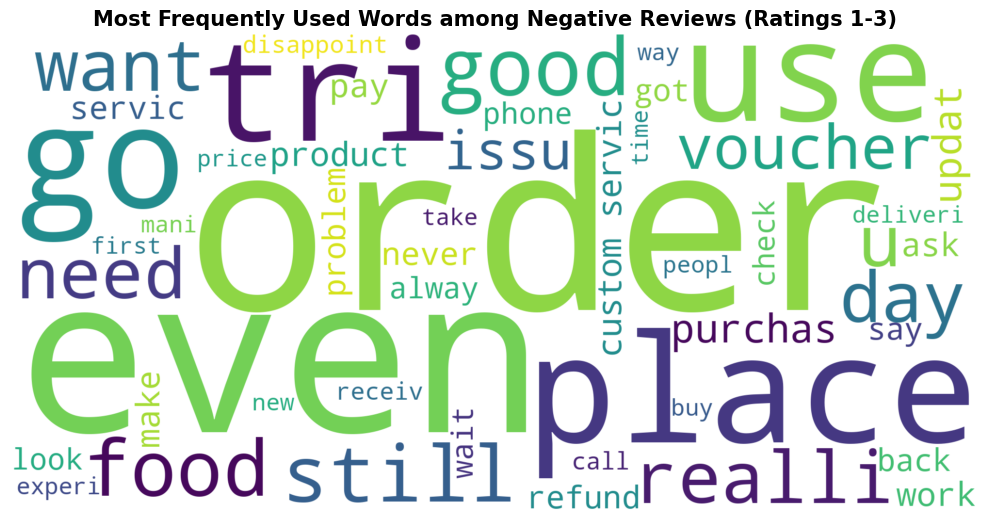

In [61]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(target=1, title='Most Frequently Used Words among Negative Reviews (Ratings 1-3)')

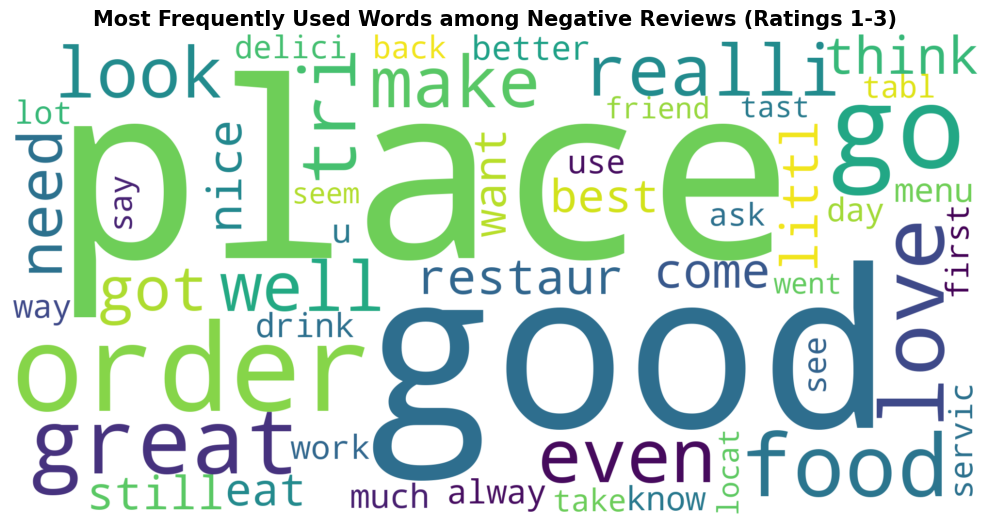

In [62]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(target=0, title='Most Frequently Used Words among Negative Reviews (Ratings 1-3)')

## Save clean datasets for modeling

In [63]:
# Keep only the columns that we need for modeling and interpretation
train = train[['content','content_stem','target']]
test = test[['content','content_stem','target']]

In [64]:
# Save clean training set
train.to_csv('../data/bigdata9_clean_train.csv', index=False)

In [65]:
# Save clean test set
test.to_csv('../data/bigdata9_clean_test.csv', index=False)

In [1]:
reviews.info()

NameError: name 'reviews' is not defined

In [80]:
# Check how many reviews were retrieved from each score
reviews['target'].value_counts().sort_index()

target
0    3913
1    2823
Name: count, dtype: int64